# Downgrade TF (Necessário restart do Runtime)

In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 3.8 MB 41.6 MB/s 
     |████████████████████████████████| 2.9 MB 47.6 MB/s 
     |████████████████████████████████| 462 kB 45.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.40.0
    Uninstalling grpcio-1.40.0:
      Successfully uninstalled grpcio-1.40.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.

In [ ]:
!pip install tensorflow-gpu==2.4.1

     |████████████████████████████████| 394.3 MB 13 kB/s 


# Carregando Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


# Checando GPU

In [ ]:
!nvidia-smi

Thu Sep 30 16:42:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Carregando Pacotes

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from pathlib import Path
import shutil

In [ ]:
print(tf.__version__)

2.4.1


# Paramêtros

In [ ]:
# Classes
num_classes = 14

# Epochs
n_epochs = 1000

# Tamanho imagem
img_rows, img_cols = 224, 224

input_shape = (img_rows, img_cols, 3)

#Batch size

batch_size = 32

# seed
seed=42

#Path base de dados Drive
nome_base = 'oregon_wildlife'
nome_zip = nome_base + '.zip'
dir_path = Path('/content/drive/MyDrive/dataset/')
zip_path = dir_path/nome_zip

In [ ]:
#loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#métricas
metrics = ['accuracy']

In [ ]:
#modelo
nome_modelo = 'resnet50' 
dir_path_modelo = Path('/content/drive/MyDrive/modelos/')
zip_name = nome_modelo + '.zip'
drive_path_modelo = dir_path_modelo/zip_name

#Carregar Base de Dados

In [ ]:
!cp {zip_path} .
!unzip -q {nome_zip} 
!rm {nome_zip}

In [ ]:
path_train = '/content/' + nome_base + '/train'
path_test = '/content/' + nome_base + '/test'

In [ ]:
train_dataset = image_dataset_from_directory(
        path_train,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=True)
test_dataset = image_dataset_from_directory(
        path_test,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False)

Found 3136 files belonging to 14 classes.
Found 784 files belonging to 14 classes.


https://www.tensorflow.org/guide/data_performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE) #Otimização
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#Data Augmentation

https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/experimental/preprocessing (TF 2.4)

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomContrast(0.2, 0.2)])

# Modelo

https://www.tensorflow.org/tutorials/images/transfer_learning

https://keras.io/guides/transfer_learning/

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet50.trainable = False #Para o primeiro treinamento as camadas convolucionais não serão treinadas
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet50(x, training=False) #Camadas de Batch Normalization em inference mode
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x) # Camada de Dropout
predictions = Dense(num_classes)(x) #Camada Densa sem ativação, pois a loss foi definida como from_logits=True
model = Model(inputs, predictions)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
______________________________________________________________

# Treinamento da Camada Densa

In [ ]:
opt_dense = keras.optimizers.Adam()
model.compile(metrics=metrics, loss=loss, optimizer=opt_dense)
callbacks_dense = [EarlyStopping(patience=10)]

In [ ]:
history_dense =model.fit(train_dataset, epochs=n_epochs, verbose=1, validation_data=test_dataset, callbacks=callbacks_dense)

Epoch 1/1000
98/98 [==============================] - 76s 392ms/step - loss: 2.2587 - accuracy: 0.3467 - val_loss: 0.5861 - val_accuracy: 0.8087
Epoch 2/1000
98/98 [==============================] - 27s 279ms/step - loss: 0.8593 - accuracy: 0.7261 - val_loss: 0.4964 - val_accuracy: 0.8227
Epoch 3/1000
98/98 [==============================] - 27s 279ms/step - loss: 0.7250 - accuracy: 0.7623 - val_loss: 0.4613 - val_accuracy: 0.8367
Epoch 4/1000
98/98 [==============================] - 27s 279ms/step - loss: 0.6085 - accuracy: 0.8081 - val_loss: 0.4536 - val_accuracy: 0.8278
Epoch 5/1000
98/98 [==============================] - 27s 279ms/step - loss: 0.6025 - accuracy: 0.7983 - val_loss: 0.4386 - val_accuracy: 0.8329
Epoch 6/1000
98/98 [==============================] - 27s 279ms/step - loss: 0.5552 - accuracy: 0.8144 - val_loss: 0.4177 - val_accuracy: 0.8508
Epoch 7/1000
98/98 [==============================] - 27s 281ms/step - loss: 0.5128 - accuracy: 0.8313 - val_loss: 0.4093 - val_ac

# Treinamento Completo

In [ ]:
resnet50.trainable = True #Liberando todas as camadas com excessão das camadas de Batch Normalization

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [ ]:
opt_completo = keras.optimizers.Adam(learning_rate=5e-6)
model.compile(metrics=metrics, loss=loss, optimizer=opt_completo)
callbacks_dense_completo = [EarlyStopping(patience=15), 
                            ModelCheckpoint(filepath=nome_modelo, save_weights_only=False, 
                                            verbose=1, monitor='val_accuracy', mode='max', 
                                            save_best_only=True)]

In [ ]:
history_completo = model.fit(train_dataset, epochs=n_epochs, verbose=1, validation_data=test_dataset, callbacks=callbacks_dense_completo)

Epoch 1/1000
98/98 [==============================] - 85s 794ms/step - loss: 0.3155 - accuracy: 0.8795 - val_loss: 0.3918 - val_accuracy: 0.8673

Epoch 00001: val_accuracy improved from -inf to 0.86735, saving model to resnet50
INFO:tensorflow:Assets written to: resnet50/assets
Epoch 2/1000
98/98 [==============================] - 76s 779ms/step - loss: 0.2536 - accuracy: 0.9135 - val_loss: 0.4006 - val_accuracy: 0.8610

Epoch 00002: val_accuracy did not improve from 0.86735
Epoch 3/1000
98/98 [==============================] - 77s 783ms/step - loss: 0.2289 - accuracy: 0.9157 - val_loss: 0.4112 - val_accuracy: 0.8610

Epoch 00003: val_accuracy did not improve from 0.86735
Epoch 4/1000
98/98 [==============================] - 76s 779ms/step - loss: 0.2175 - accuracy: 0.9178 - val_loss: 0.3839 - val_accuracy: 0.8648

Epoch 00004: val_accuracy did not improve from 0.86735
Epoch 5/1000
98/98 [==============================] - 77s 782ms/step - loss: 0.2049 - accuracy: 0.9191 - val_loss: 0.3

# Resultados

In [ ]:
best_model = tf.keras.models.load_model(nome_modelo) # Carregando melhor modelo
predict = best_model.predict(test_dataset)
predicted_classes = np.argmax(predict, axis=1)

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
print(confusion_matrix(y_true, predicted_classes))

[[55  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 55  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 48  5  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  6 47  0  1  0  0  2  0  0  0  0  0]
 [ 0  0  2  0 36  2  0 16  0  0  0  0  0  0]
 [ 0  0  0  2  1 52  0  0  0  1  0  0  0  0]
 [ 0  0  2  1  2  0 47  0  4  0  0  0  0  0]
 [ 0  0  1  0  6  1  0 48  0  0  0  0  0  0]
 [ 0  2  0  0  0  2  7  0 43  0  0  0  0  2]
 [ 0  1  1  0  0  0  0  0  0 53  0  0  0  1]
 [ 0  0  0  0  1  0  0  0  0  0 55  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0 51  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13 43  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 55]]


In [ ]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.95      0.98      0.96        56
           2       0.77      0.86      0.81        56
           3       0.84      0.84      0.84        56
           4       0.78      0.64      0.71        56
           5       0.88      0.93      0.90        56
           6       0.84      0.84      0.84        56
           7       0.75      0.86      0.80        56
           8       0.88      0.77      0.82        56
           9       0.98      0.95      0.96        56
          10       1.00      0.98      0.99        56
          11       0.80      0.91      0.85        56
          12       0.90      0.77      0.83        56
          13       0.95      0.98      0.96        56

    accuracy                           0.88       784
   macro avg       0.88      0.88      0.88       784
weighted avg       0.88      0.88      0.88       784



In [ ]:
acc = accuracy_score(y_true, predicted_classes)
print("{:.4f}".format(acc))

0.8776


# Gráficos treinamento

In [ ]:
pd_history_1 = pd.DataFrame(history_dense.history)
pd_history_2 = pd.DataFrame(history_completo.history)
history=pd.concat([pd_history_1, pd_history_2], ignore_index=True)
history.index += 1

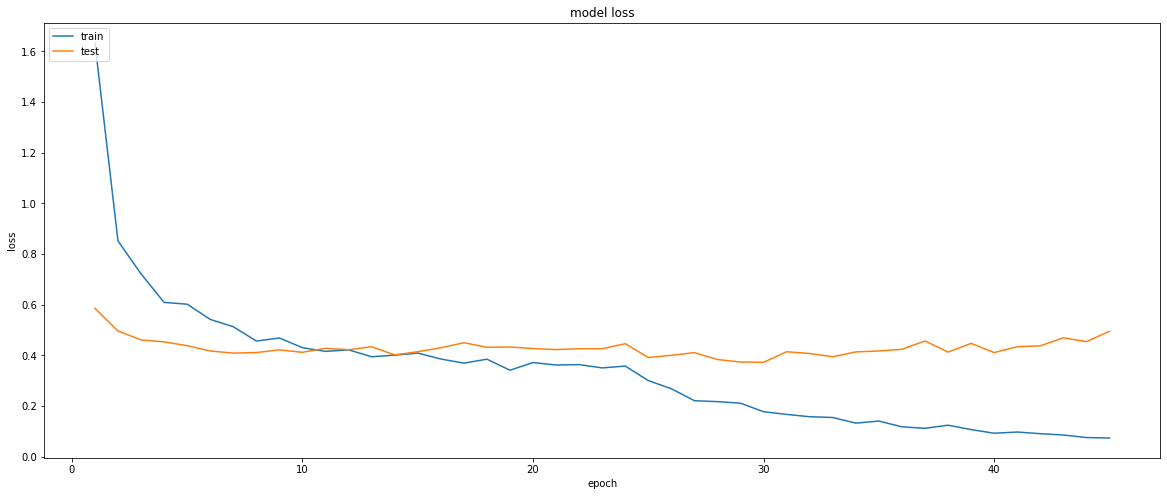

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

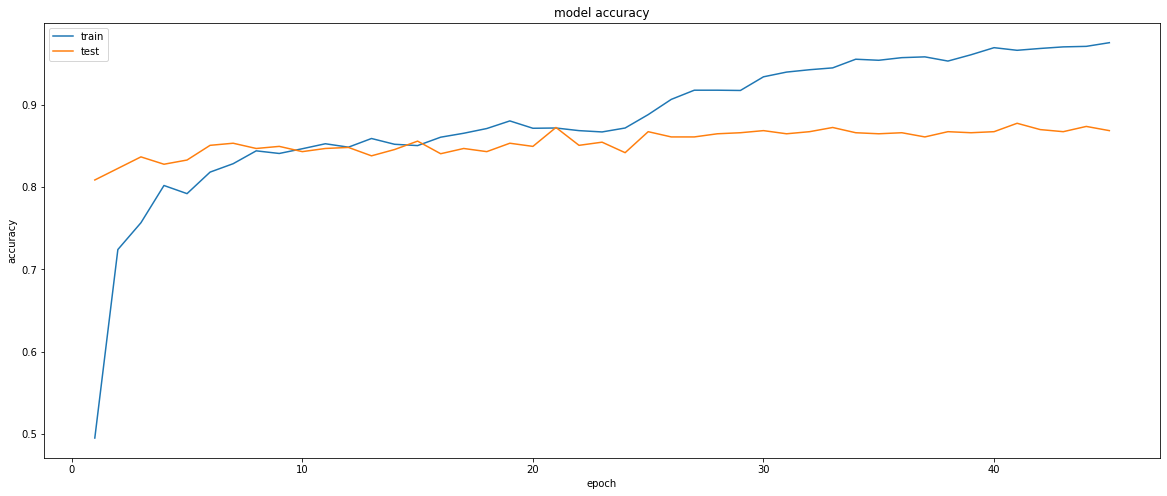

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Copiando para o Drive

In [ ]:
!zip -r {zip_name} {nome_modelo}

  adding: resnet50/ (stored 0%)
  adding: resnet50/variables/ (stored 0%)
  adding: resnet50/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: resnet50/variables/variables.index (deflated 80%)
  adding: resnet50/assets/ (stored 0%)
  adding: resnet50/saved_model.pb (deflated 93%)


In [ ]:
shutil.copyfile(zip_name, drive_path_modelo)

PosixPath('/content/drive/MyDrive/modelos/resnet50.zip')